# Xarray interface for neoclassical transport

## `SymbolicEquilibrium`

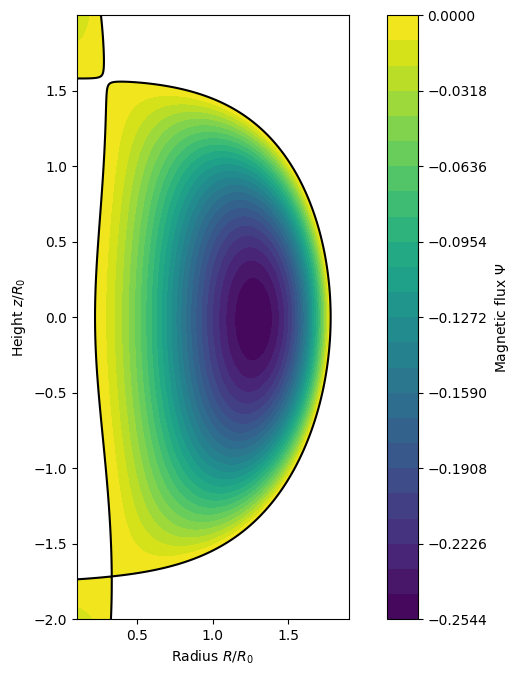

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 1.25, "A": -0.05, "elongation": 2, "triangularity": 0.3}
# TODO this is still not taken in

eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null",
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

In [2]:
from tqdm.auto import tqdm

In [3]:
import astropy.units as u
import numpy as np
import pandas as pd
import xarray

data_df = pd.read_csv("/home/dominik/home-import/IFPILM/Magisterka/HoulbergNSTX.csv", index_col=0)

,x,ToverT0,neoverne0,Zeff,Zeff_derivative,n_C,n_e,n_D_charge,n_D_zeff_no_square,charge_density_charge,charge_density_zeff_no_square,n_D,Zeff_reproduced,ToverT0_derivative,n_e_derivative,n_C_derivative,n_D_derivative
0,0.00000,1.00000,1.00000,1.368766,0.023928,5.000000e+18,9.500000e+19,6.500000e+19,1.000328e+20,0.0,3.503280e+19,1.000328e+20,1.105608,-0.000000,-0.000000e+00,0,2.273142e+18
1,0.00560,0.99833,1.00077,1.368878,0.024050,5.000000e+18,9.507315e+19,6.507315e+19,1.001435e+20,0.0,3.507038e+19,1.001435e+20,1.105922,-0.010304,-5.320083e+17,0,1.558279e+18
2,0.05209,0.99728,0.99963,1.369874,0.025117,5.000000e+18,9.496485e+19,6.496485e+19,1.000899e+20,0.0,3.512507e+19,1.000899e+20,1.106619,-0.095850,-4.955277e+18,0,-4.402854e+18
3,0.08060,0.99604,0.99688,1.370554,0.025820,5.000000e+18,9.470360e+19,6.470360e+19,9.979641e+19,0.0,3.509281e+19,9.979641e+19,1.106573,-0.148310,-7.681993e+18,0,-8.083370e+18
4,0.11061,0.98880,0.99366,1.371334,0.026603,5.000000e+18,9.439770e+19,6.439770e+19,9.945078e+19,0.0,3.505308e+19,9.945078e+19,1.106497,-0.203531,-1.057283e+19,0,-1.198763e+19
5,0.11063,0.98879,0.99366,1.371335,0.026603,5.000000e+18,9.439770e+19,6.439770e+19,9.945083e+19,0.0,3.505313e+19,9.945083e+19,1.106498,-0.203568,-1.057476e+19,0,-1.199024e+19
6,0.18263,0.96947,0.98650,1.373528,0.028691,5.000000e+18,9.371750e+19,6.371750e+19,9.872359e+19,0.0,3.500609e+19,9.872359e+19,1.106769,-0.336054,-1.764664e+19,0,-2.154926e+19
7,0.18270,0.96945,0.98649,1.373530,0.028694,5.000000e+18,9.371655e+19,6.371655e+19,9.872251e+19,0.0,3.500596e+19,9.872251e+19,1.106768,-0.336183,-1.765363e+19,0,-2.155874e+19
8,0.24879,0.94524,0.97351,1.376053,0.030921,5.000000e+18,9.248345e+19,6.248345e+19,9.726215e+19,0.0,3.477870e+19,9.726215e+19,1.105735,-0.457794,-2.440232e+19,0,-3.071918e+19
9,0.25468,0.94242,0.97203,1.376307,0.031137,5.000000e+18,9.234285e+19,6.234285e+19,9.709213e+19,0.0,3.474928e+19,9.709213e+19,1.105577,-0.468632,-2.501961e+19,0,-3.155941e+19


<AxesSubplot:xlabel='x'>

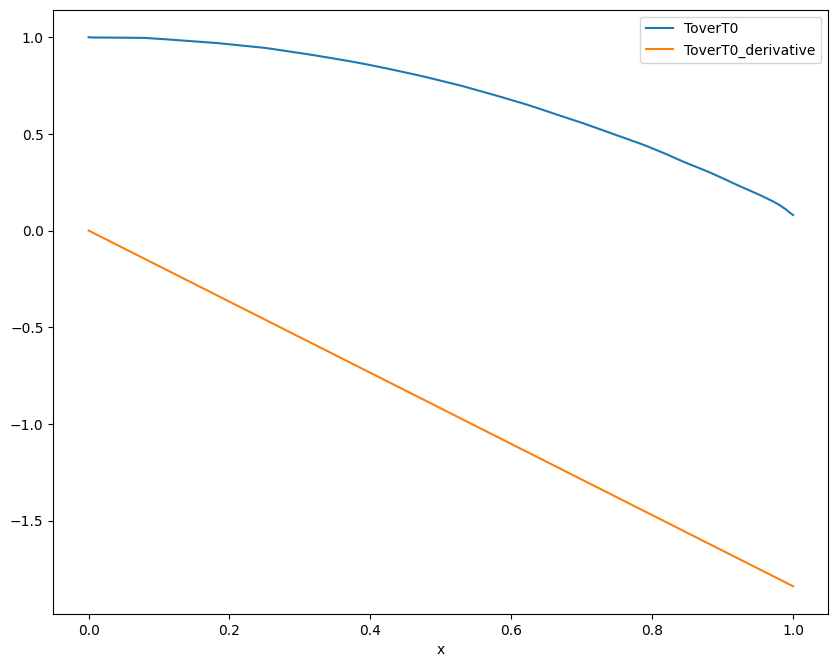

In [4]:
data_df[["x", "ToverT0", "ToverT0_derivative"]].plot(x="x")

<AxesSubplot:xlabel='x'>

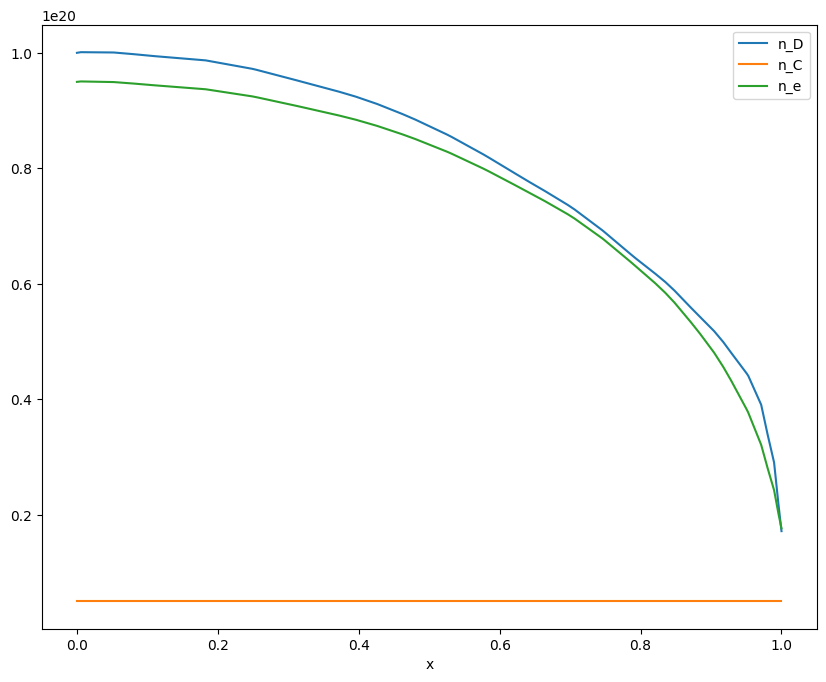

In [5]:
data_df[["x", "n_D", "n_C", "n_e"]].plot(x="x")

<AxesSubplot:xlabel='x'>

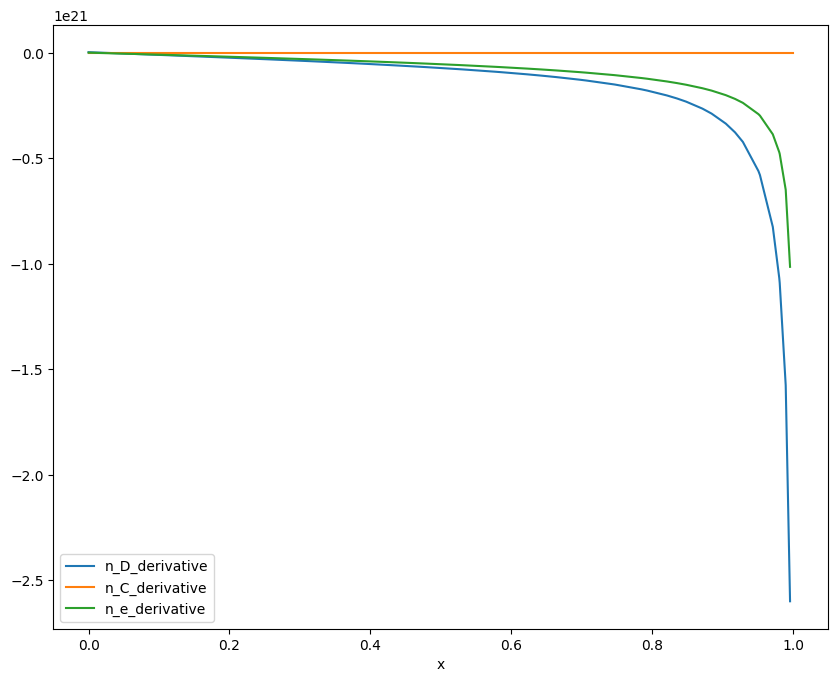

In [6]:
data_df[["x", "n_D_derivative", "n_C_derivative", "n_e_derivative"]].plot(x="x")

In [7]:
T_i = T_e = T_C6 = data_df["ToverT0"] * 0.5 * 1000
dT_i = dT_e = dT_C6 = data_df["ToverT0_derivative"] * 0.5 * 1000
n_e, dn_e = data_df["n_e"], data_df["n_e_derivative"]
n_i, dn_i = data_df["n_D"], data_df["n_D_derivative"]
n_C6, dn_C6 = data_df["n_C"], data_df["n_C_derivative"]

rho = data_df.x.values

array([0.     , 0.0056 , 0.05209, 0.0806 , 0.11061, 0.11063, 0.18263,
       0.1827 , 0.24879, 0.25468, 0.31192, 0.32376, 0.37206, 0.39584,
       0.42621, 0.46194, 0.48038, 0.52506, 0.53156, 0.57674, 0.5852 ,
       0.62193, 0.64235, 0.66413, 0.6965 , 0.70633, 0.74553, 0.74768,
       0.78473, 0.79287, 0.82094, 0.83506, 0.84812, 0.87127, 0.88433,
       0.90449, 0.91755, 0.9287 , 0.95076, 0.95293, 0.97116, 0.98032,
       0.98098, 0.98948, 0.99565, 1.     ])

## Multiple flux surfaces - radial grid

## `FlowCalculator`

In [8]:
import xarray
attrs = {
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    }

dataset_H1 = xarray.Dataset(
    {
        "T": ("rho", T_i),
        "gradT": ("rho", dT_i),
        "n": ("rho", n_i),
        "gradn": ("rho", dn_i),
        "charges": 1,
    },
    coords={"rho": rho, "particle": "H 1+"},
    attrs=attrs,
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("rho", T_C6),
        "gradT": ("rho", dT_C6),
        "n": ("rho", n_C6),
        "gradn": ("rho", dn_C6),
        "charges": 6,
    },
    coords={"rho": rho, "particle": "C 6+"},
    attrs=attrs,
)
dataset_e = xarray.Dataset(
    {
        "T": ("rho", T_e),
        "gradT": ("rho", dT_e),
        "n": ("rho", n_e),
        "gradn": ("rho", dn_e),
        "charges": -1,
    },
    coords={"rho": rho, "particle": "e-"},
    attrs=attrs,
)

dataset = xarray.concat([
    dataset_H1,
    dataset_C6,
    dataset_e,
], dim="particle")
# dataset["rho"] = ("rho", rho)
dataset["charge_density"] = "rho", (dataset.charges * dataset.n).sum(dim="particle")
dataset

<xarray.Dataset>
Dimensions:         (particle: 3, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -0.0 -5.152 -47.92 ... -916.0 -920.0
    n               (particle, rho) float64 1e+20 1.001e+20 ... 1.763e+19
    gradn           (particle, rho) float64 2.273e+18 1.558e+18 ... -inf
    charges         (particle) int64 1 6 -1
    charge_density  (rho) float64 3.503e+19 3.507e+19 ... 3.164e+19 2.952e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [9]:
dataset["psi"] = eq.rho_to_psi(rho)
dataset

<xarray.Dataset>
Dimensions:         (particle: 3, psi: 46, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
  * psi             (psi) float64 -0.2544 -0.2529 -0.2411 ... -0.001106 0.0
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -0.0 -5.152 -47.92 ... -916.0 -920.0
    n               (particle, rho) float64 1e+20 1.001e+20 ... 1.763e+19
    gradn           (particle, rho) float64 2.273e+18 1.558e+18 ... -inf
    charges         (particle) int64 1 6 -1
    charge_density  (rho) float64 3.503e+19 3.507e+19 ... 3.164e+19 2.952e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [10]:
# final_dataset = dataset

final_rho = np.linspace(0.61277, 0.61282, 500)
final_rho = np.linspace(0, 1, 50)
final_dataset = dataset.interp({"rho": final_rho})

<xarray.Dataset>
Dimensions:         (particle: 3, psi: 46, rho: 50)
Coordinates:
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
  * psi             (psi) float64 -0.2544 -0.2529 -0.2411 ... -0.001106 0.0
  * rho             (rho) float64 0.0 0.02041 0.04082 ... 0.9592 0.9796 1.0
Data variables:
    T               (particle, rho) float64 500.0 499.0 498.8 ... 66.99 39.98
    gradT           (particle, rho) float64 -0.0 -18.78 -37.55 ... -901.3 -920.0
    n               (particle, rho) float64 1e+20 1.001e+20 ... 1.763e+19
    gradn           (particle, rho) float64 2.273e+18 -3.405e+17 ... -inf
    charges         (particle) int64 1 6 -1
    charge_density  (rho) float64 3.503e+19 3.509e+19 ... 3.591e+19 2.952e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [ ]:
from plasmapy.transport.flows import FlowCalculator
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
fcs = []
surfaces = []
all_mu = []
datasets = []
for i, (_, surface) in enumerate(tqdm(
        eq.get_multiple_flux_surfaces(
            rho_values=final_dataset.rho, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep
        ),
        total=final_dataset.rho.size,
    )):
    surfaces.append(surface)
    surface.plot(ax)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fc = FlowCalculator.from_xarray_surface(final_dataset.isel(rho=i), surface)
    fcs.append(fc)
    all_species = fc.all_species
    all_mu.append(all_species.mu_hat(surface))
    dataset = fc.to_dataset()
    datasets.append(dataset)
ax.legend().remove()

  0%|          | 0/50 [00:00<?, ?it/s]

/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__a

In [ ]:
results = xarray.concat(datasets, dim="rho")
results["mu_hat"] = ("rho", "particle", "alpha", "beta"), u.Quantity(all_mu).si.value
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m ** 2)
results = results.assign(
    bootstrap_current_normalized=results.bootstrap_current * scaling
)

In [ ]:
results.bootstrap_current_normalized.plot.line()

In [ ]:
# imax = int(np.abs(results.bootstrap_current_normalized).argmax())
# extr = results.isel(psi=imax, rho=imax)

# fs = surfaces[imax][1]

# fc = fcs[imax]

# all_species = fc.all_species

# results["effective_momentum_relaxation_"]

In [ ]:
# results.sel(particle="e-").mu_hat.mean(dim=["alpha", "beta"]).plot.line(x="rho")

In [ ]:
eq.get_flux_surface

In [ ]:
# rho_to_surface[float(extr.rho)]

# surfaces[imax]

# surfaces[imax]

results.thermal_conductivity

In [ ]:
results.diffusion_coefficient.sel(particle="C 6+")

In [ ]:
results.diffusion_coefficient.plot.line(x="rho")
plt.xlim(0, 0.8)
plt.ylim(-10, 10)

In [ ]:
results.thermal_conductivity.plot.line(x="rho")

In [ ]:
results.total_particle_flux.plot.line(x="rho")

In [ ]:
results.CL_particle_flux.plot.line(x="rho")

In [ ]:
results.BP_particle_flux.plot.line(x="rho")

In [ ]:
results.PS_particle_flux.plot.line(x="rho")

In [ ]:
import pandas as pd

df = pd.read_csv("/home/dominik/home-import/IFPILM/Magisterka/NSTXplot1.csv")
paper_results = xarray.Dataset.from_dataframe(df).swap_dims({"index": "x"}).drop("index").rename({"x": "rho"})

for values in paper_results:
    paper_results[values].plot.line(x="rho", label=values)
results.bootstrap_current_normalized.plot.line(x="rho", label="My bootstrap current")
plt.legend()
plt.ylim(0, 0.2)

In [ ]:
paper_results2 = paper_results.interp({"rho": results.rho})
diff = paper_results2 / results.bootstrap_current_normalized
diff = diff.where(diff.rho > 0.1)
for key in diff:
    diff[key].plot.line(x="rho", label=key)
plt.legend()

In [ ]:
directions = ["poloidal", "toroidal", "parallel", "perpendicular"]
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    surfaces[5][1].plot(
        ax, quantity=fcs[-5].local_flow_velocities["H 1+"][index].value, legend=False
    )
    ax.set_title(label)

In [ ]:
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    for (psi, surface), fc in zip(surfaces, fcs):
        surface.plot(
            ax,
            quantity=fc.local_flow_velocities["H 1+"][index].value,
            legend=False,
            colorbar=False,
        )
    ax.set_title(label)